<a href="https://colab.research.google.com/github/FinEckhoff/AI/blob/master/ImageGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt
import time
from IPython import display
import os

tf.device('/device:GPU:0')

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [2]:

model = tf.keras.Sequential()
model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Reshape((7, 7, 256)))
assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
assert model.output_shape == (None, 7, 7, 128)
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert model.output_shape == (None, 14, 14, 64)
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert model.output_shape == (None, 28, 28, 1)

generator = model

In [3]:
discriminator = tf.keras.Sequential()

discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))


In [16]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [5]:
def showImage(image):
  plt.imshow(image[0, :, :, 0], cmap='gray')

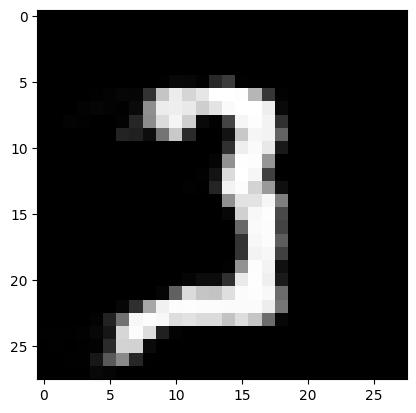

In [17]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [7]:
discriminator(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0039514]], dtype=float32)>

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [9]:
EPOCHS = 60
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [10]:
@tf.function
def train_step(images):

    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using
    # operations recorded in context of this tape (gen_tape and disc_tape).

    # It accepts a target (e.g., gen_loss) variable and
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors
    # (or IndexedSlices, or None), one for each element in sources.
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients.
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [11]:
def train(dataset, epochs):
  with tf.device('/device:GPU:0'):
    # A. For each epoch, do the following:
    for epoch in range(epochs):
      start = time.time()
      # 1 - For each batch of the epoch,
      for image_batch in dataset:
        # 1.a - run the custom "train_step" function
        # we just declared above
        train_step(image_batch)

      # 2 - Produce images for the GIF as we go
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                              epoch + 1,
                              seed)

      # 3 - Save the model every 5 epochs as
      # a checkpoint, which we will use later
      if (epoch + 1) % 30 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

      # 4 - Print out the completed epoch no. and the time spent
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # B. Generate a final image after the training is completed
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

In [12]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

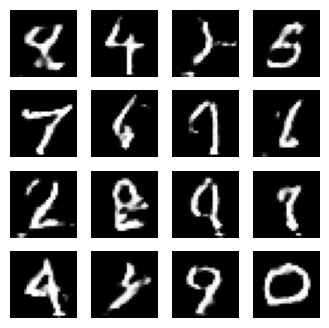

In [19]:
train(train_dataset, EPOCHS)

In [14]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

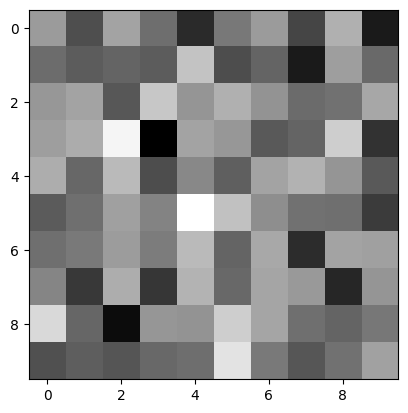

In [ ]:
noise = tf.random.normal([1, 100])

showImage(tf.reshape(noise, shape=(1,10,10,1)))



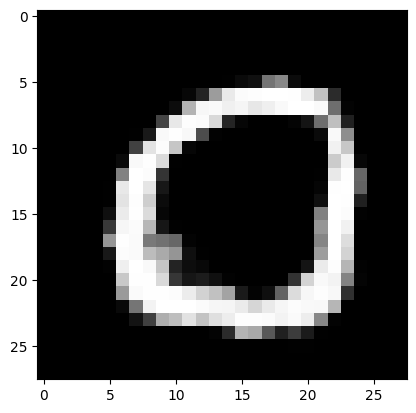

In [15]:
noise = tf.random.normal([1, 100])
showImage(generator(noise, training=False))